In [17]:
import pandas as pd
from sklearn.metrics import silhouette_score

# Chargez le fichier CSV dans un DataFrame pandas
df = pd.read_csv("dataTp2.csv")

# Affichez les premières lignes du DataFrame(Test).
df.head()


,Unnamed: 0,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,2157,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,1223,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,1083,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,456,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,1448,0.458818,0.483091,0.406909,0.297818,0.395273,0


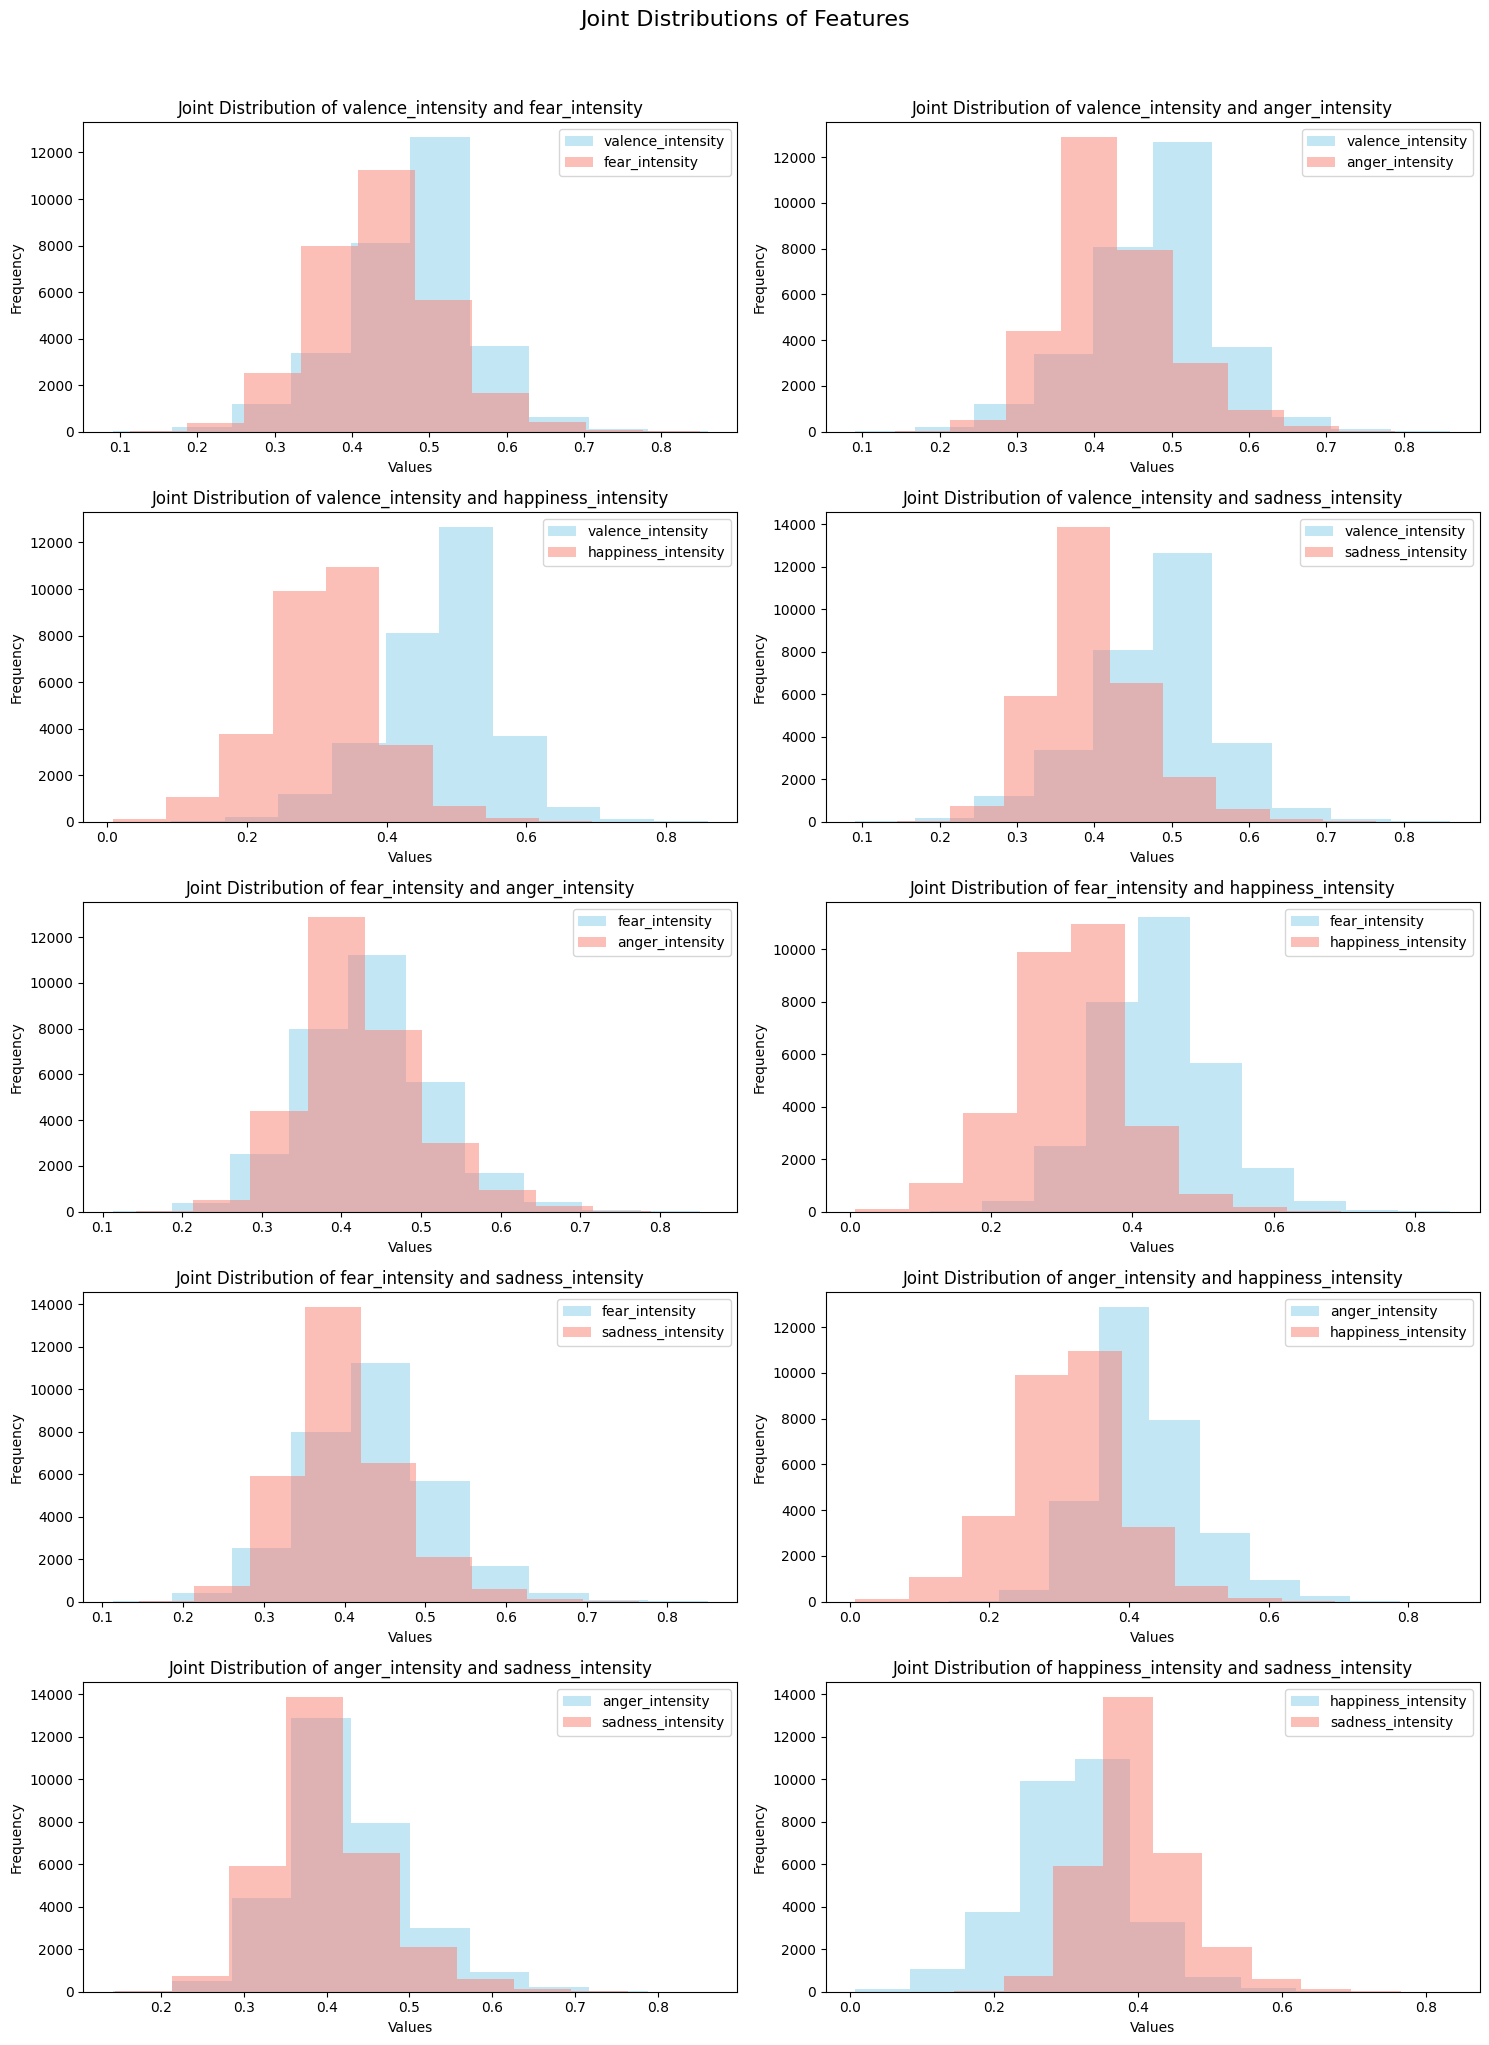

In [2]:
import matplotlib.pyplot as plt

# Select the features for joint distribution plots
selected_features = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']

# Create all possible pairs of features
feature_pairs = [(feature1, feature2) for i, feature1 in enumerate(selected_features) for feature2 in selected_features[i+1:]]

# Create the joint distribution histogram plots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Joint Distributions of Features', y=1.02, fontsize=16)

for i, (feature1, feature2) in enumerate(feature_pairs):
    row, col = divmod(i, 2)

    # Plotting histograms with different colors for each feature
    axes[row, col].hist(df[feature1], bins=10, color='skyblue', alpha=0.5, label=feature1)
    axes[row, col].hist(df[feature2], bins=10, color='salmon', alpha=0.5, label=feature2)

    axes[row, col].set_title(f'Joint Distribution of {feature1} and {feature2}')
    axes[row, col].set_xlabel('Values')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

In [3]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=159af8470a1e9cf3a03c63fded1cf9cb5daf3a88f17a47569f6fa5a445c44259
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [4]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=b46e91945935717633e540df8fdafc46c297e461b91bbd77a78d56b23ee71bbd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


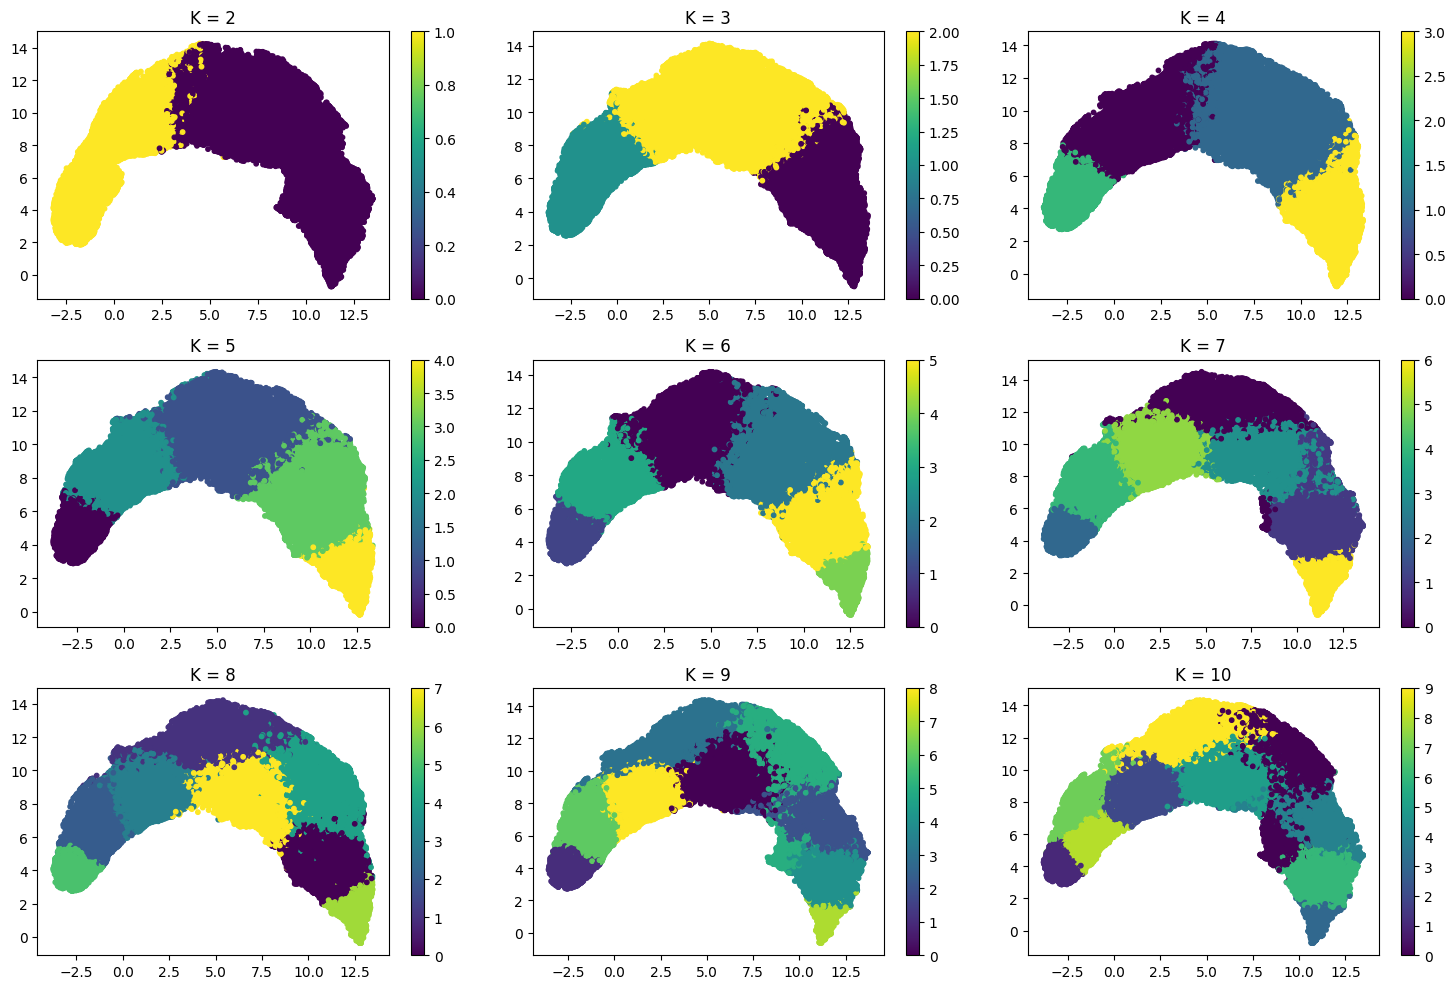

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sélectionner les caractéristiques pour l'analyse K-means
features = df[['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']]
# Appliquer K-means pour différentes valeurs de K
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = {}

plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values, 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster_k{}'.format(k)] = kmeans.fit_predict(features)
    cluster_labels = df['cluster_k{}'.format(k)]
    silhouette_scores[k] = silhouette_score(features, cluster_labels)

    # Import UMAP from umap-learn
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)

    plt.subplot(3, 3, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=10)
    plt.title('K = {}'.format(k))
    plt.colorbar()

plt.tight_layout()
plt.show()

**Question 3:**

In [6]:
def cluster(k, nb_cluster):
    if nb_cluster >= k:
        raise ValueError("nb_cluster must be less than k")
    df_k = (df[f'cluster_k{k}'] == nb_cluster)
    return df[df_k][selected_features]

In [7]:
def calculate_cluster_centers(k, line=None):
    """
    Calculate the centers of the clusters for a given k.
    """
    centers = {}
    for cluster in range(k):
        df_k = (df[f'cluster_k{k}'] == cluster)
        cluster_data = df[df_k][selected_features]
        centers[cluster] = cluster_data.mean().values
    centers_df = pd.DataFrame(centers).T
    if line is not None:
        return centers_df.iloc[line]
    return centers_df

In [8]:
from sklearn.metrics import pairwise_distances
from itertools import combinations
from sklearn.metrics import precision_recall_fscore_support
def calculate_intra_cluster_distance(k, nb_cluster, distance_type='euclidean'):
    cluster_data = cluster(k, nb_cluster)
    cluster_center = calculate_cluster_centers(k, nb_cluster).values.reshape(1, -1)

    # Calculate the distances from all points in the cluster to the cluster center
    distances = pairwise_distances(cluster_data, cluster_center, metric=distance_type)

    # Return the maximum distance (which represents the intra-cluster distance)
    return distances.max()

In [9]:
def calculate_inter_cluster_distance(k, nb_cluster1, nb_cluster2, distance_type='euclidean'):

    cluster_data1 = cluster(k, nb_cluster1)
    center_1 = calculate_cluster_centers(k, nb_cluster1).values.reshape(1, -1)

    cluster_data2 = cluster(k, nb_cluster2)
    center_2 = calculate_cluster_centers(k, nb_cluster2).values.reshape(1, -1)

    # Calculate the distances from the center of cluster 1 to all points in cluster 2
    distances_1_to_2 = pairwise_distances(center_1, cluster_data2, metric=distance_type)

    # Calculate the distances from the center of cluster 2 to all points in cluster 1
    distances_2_to_1 = pairwise_distances(center_2, cluster_data1, metric=distance_type)

    # Return the minimum distance between the two sets of distances
    return min(distances_1_to_2.min(), distances_2_to_1.min())

In [10]:
def overlap_k(k, nb_cluster1 , nb_cluster2, distance_type='euclidean'):
    num = calculate_intra_cluster_distance(k, nb_cluster1, distance_type) + calculate_intra_cluster_distance(k, nb_cluster2, distance_type)
    den = 2 * calculate_inter_cluster_distance(k, nb_cluster1, nb_cluster2, distance_type)
    return num / den

In [20]:
def overlap(k, distance_type='euclidean'):

    overlap_values = []

    # Generate all combinations of cluster pairs for the given k
    for cluster_pair in combinations(range(k), 2):
        nb_cluster1, nb_cluster2 = cluster_pair

        # Calculate the overlap for the current pair of clusters
        overlap_value = overlap_k(k, nb_cluster1, nb_cluster2, distance_type)

        # Store the overlap values
        overlap_values.append(overlap_value)

    return overlap_values

In [25]:
from tabulate import tabulate
overlap_scores = {}

# Choix des valeurs de k
k_values = [2, 3, 4, 5, 6, 7, 8, 9]  # Ajoutez d'autres valeurs de k si nécessaire

# Calcul des overlaps pour chaque valeur de k
for k_value in k_values:
    overlaps = overlap(k_value)
    overlap_scores[k_value] = overlaps

# Affichage des overlaps pour chaque valeur de k dans des tableaux
table_count = 0
table_size = 5  # Nombre de tableaux par page
for k_value, overlaps in overlap_scores.items():
    if table_count % table_size == 0:
        print(f"Tableau {table_count // table_size + 1}")
    print(f"Overlaps for K={k_value}:")
    headers = ["Cluster Pair", "Overlap Value"]
    table_data = []
    for i, overlap_value in enumerate(overlaps, 1):
        cluster_pair = [x for x in combinations(range(k_value), 2)][i - 1]
        table_data.append([cluster_pair, overlap_value])
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print("\n---------------------------")
    table_count += 1
    if table_count % table_size == 0 or k_value == k_values[-1]:
        print("\n")

Tableau 1
Overlaps for K=2:
+----------------+-----------------+
| Cluster Pair   |   Overlap Value |
+================+=================+
| (0, 1)         |         4.38029 |
+----------------+-----------------+

---------------------------
Overlaps for K=3:
+----------------+-----------------+
| Cluster Pair   |   Overlap Value |
+================+=================+
| (0, 1)         |         1.74505 |
+----------------+-----------------+
| (0, 2)         |         4.48541 |
+----------------+-----------------+
| (1, 2)         |         3.37811 |
+----------------+-----------------+

---------------------------
Overlaps for K=4:
+----------------+-----------------+
| Cluster Pair   |   Overlap Value |
+================+=================+
| (0, 1)         |         3.62716 |
+----------------+-----------------+
| (0, 2)         |         3.3582  |
+----------------+-----------------+
| (0, 3)         |         1.61623 |
+----------------+-----------------+
| (1, 2)         |         

In [19]:
pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['Silhouette Score'])
overlap_df = pd.DataFrame.from_dict(overlap_scores, orient='index', columns=['Overlap Score'])
silhouette_df = pd.DataFrame.from_dict(silhouette_scores, orient='index', columns=['Silhouette Score'])

merged_df = pd.concat([overlap_df, silhouette_df], axis=1)
merged_df

,Overlap Score,Silhouette Score
2,4.380290,0.430931
3,3.202858,0.342324
4,2.608414,0.296540
5,2.291798,0.261128
6,2.241748,0.215153
7,2.254141,0.204661
8,2.138930,0.199817
9,2.027625,0.195870
10,1.984254,0.194793


**Q4**

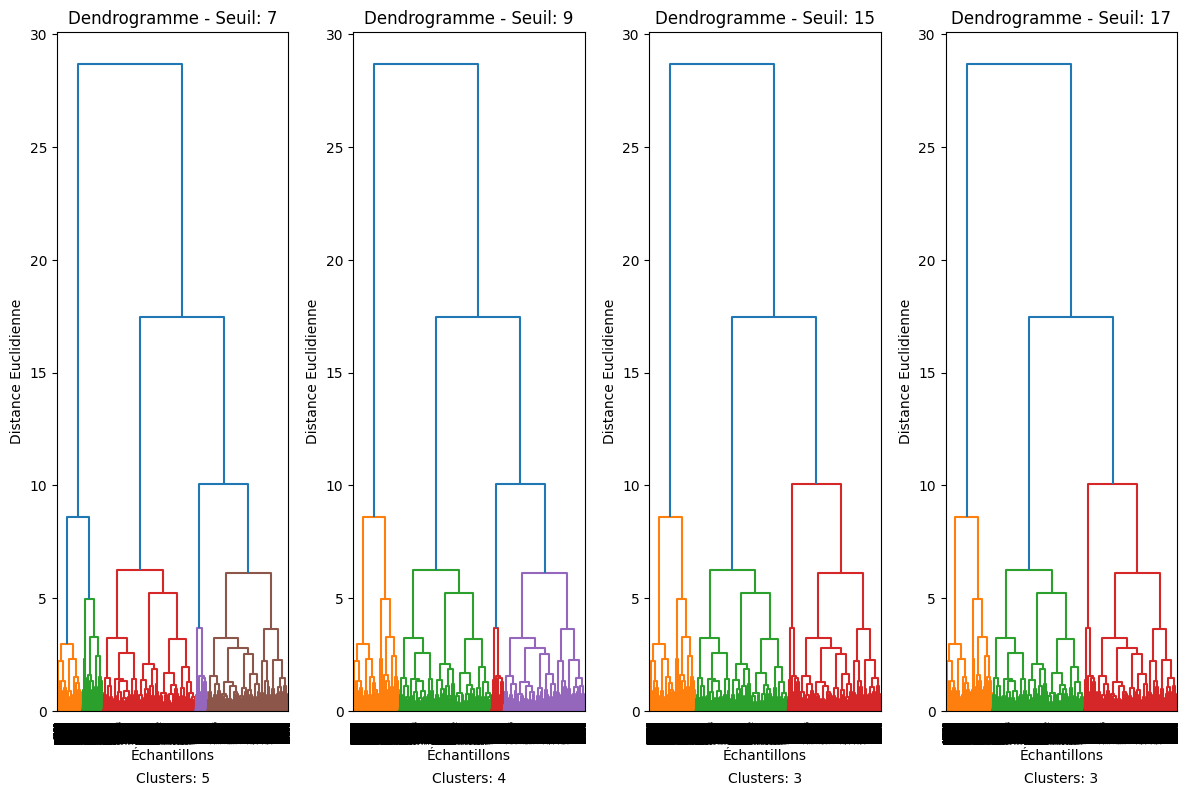

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Sélectionner les colonnes pertinentes pour le clustering
selected_columns = ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
X = df[selected_columns].values

# Fonction pour afficher les dendrogrammes avec le nombre de clusters pour des seuils spécifiques
def plot_dendrogram(X):
    thresholds = [7, 9, 15, 17]  # Seuils spécifiques à tester
    plt.figure(figsize=(12, 8))
    for i, threshold in enumerate(thresholds):
        plt.subplot(1, len(thresholds), i+1)
        linked = linkage(X, method='ward')  # Utilisation de 'ward' pour la liaison
        dendrogram(linked, color_threshold=threshold)
        plt.title(f'Dendrogramme - Seuil: {threshold}')
        plt.xlabel('Échantillons')
        plt.ylabel('Distance Euclidienne')

        # Calcul du nombre de clusters pour chaque seuil
        clusters = fcluster(linked, t=threshold, criterion='distance')
        unique_clusters = np.unique(clusters)
        plt.text(0.5, -0.1, f'Clusters: {len(unique_clusters)}', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher les dendrogrammes avec le nombre de clusters pour les seuils spécifiques
plot_dendrogram(X)
